<h1>Modeling spread of communicable disease</h1>

With COVID-19, we understand how important it is to model the spread of disease to control the outbreak of pandemics (or epidemics). In this tutorial, lets use a simple model to understand how the infection spreads among population. At the end of this tutorial, we should be comfortable with:

1) Objects and Classes <br>
2) How simulation model are built (an idea of simulation)<br>
3) Matrix multiplication and used of vectorization (using a matrix form)<br>

<b>Problem at hand</b> <br>
We consider a population of n people. We want to understand how the infection spreads over time if one person in the population is infected. We can impose policies like quarantine and see how it affects the spread. We can also test different scenarios as what happens if the diseases is highly contagious vs mildly contagious. 

<b>What is simulation?</b> <br>
In a lot of complicated systems, we cannot the system theoretically. For example, in manufacturing systems, where products move along product lines, theoretical models of queueing networks can't work beyond two machines. Similarly, in COVID-19, we have to come with different simulation models to check multiple what-if scenarios for important decisions e.g. lockdowns, making mask comulsory etc. In this workbook, lets build a simple simulation model and build understanding of epidemiology.

Random numbers are the backbone of simulation models. Because we don't model theoretical models, we simulate the system using random numbers. For example, the probability that an infected person infects you is modeled using a randomly drawn probability. We should be careful that the random numbers we draw should be in correspondence with actual reality (we need to check the probability distribution we are drawing the random numbers from). Also make sure that we can draw random numbers from the desired distribution. In this exercise, we will draw random numbers from known distribution. If we have to draw numbers from a weird looking (unnamed distribution), we need to consider advanced techniques, e.g. importance sampling, acceptance regions method, MCMC.

In [331]:
# libraries to be used in this tutorial

import numpy as np
import matplotlib.pyplot as mplt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline 

from scipy.spatial.distance import pdist, squareform,cdist
import scipy.integrate as integrate

#NOTE: you need ffmpeg video writer to run this code. You can use conda install ffmpeg if using anaconda for python

<h2>Classes and Objects</h2>

<b>Object oriented programming</b> is a programming paradigm that structures coding such that properties or behavior are bundled as individual objects. Although, python is not completely an object oriented programming language, like JAVA, we can still structure our programming in this format

We will proceed with OOP using an example. We build a <b>class - human</b> and model individuals as <b>objects or instance of class - human</b>. So human is the class and all of us are the instances of the class human. We can build other classes e.g. countries and human can be the superclass of the subclass country (as country includes individuals who come from the class human)
<br>
<img src="fig1.png" width="500">


<center>Class and Objects (image from <a href="https://www.wikitechy.com/tutorials/python/python-object-class">here</a>)</center>

In [573]:
class Human():
    def __init__(self,name,age,infected): # self is always there in the init function
        self.name        = name           # assinging names to individuals
        self.age         = age            # when we create individuals, we add information 
        self.infected    = infected       # infected or not
        self.quarantined = 0              # in the start of the quarantine, the individuals are not quarantined
        self.compartment = 100            # intially there is no quarantine so there is 1 compartment (x location of right side)
        
        # x and y location of the individual
        self.x           = np.random.uniform(-100,100)
        self.y           = np.random.uniform(-100,100)

In [618]:
# creating n individuals (instances of the class human)

def CreatePopulation(n,n_inf,n_com):
    population = []

    for i in range(n):
        name = i+1
        age  = int(np.random.uniform(10,50)) # randomly creating age of the individual (drawing from uniform distribution)
        infected = 0
        if n-i<=n_inf:
            infected = 1
            
        # ------- creating an "instance" or "object" from the "class" -------   
        individual = Human(name,age,infected)   # assuming that only the last individual is infected
        # -------------------------------------------------------------------
        
        # finding the compartment in which the user lies (putting the right extreme of the compartment)
        xr = 100
        if n_com > 1:
            xl = 100
            for c in range(n_com-1):
                xl = -100+200*(c+1)/(n_com)
                if individual.x < xl:
                    xr = xl
                    break
            individual.compartment = xr

        #adding the individual to the population
        population.append(individual)
    
    return(population)

<h2>Building simulation infrastructure</h2>

In [619]:
# lets consider that the population live in an area as shown in the box
# and each individual is a circle
# infected individuals are shown in red, rest in green
# if an infected individual comes close to an uninfected individual, it spreads the disease with probability p

# these are our model parameters, play with these numbers to see how the infection rate changes with time
# these scenarios can then be used by governments for policy decisions

N     = 100
p_inf = 0.5   # probability of infecting by an infected individual (could be effect of wearing mask)
n_inf = 10    # total number of infected when we start the simulation (how soon the model be used to take action)
D     = 60    # number of days for which the simulation is to be run
n_com = 1     # number of compartments
dist  = 5     # range of a point where a user can move from its current point
move  = 5     # how much an individual move in the region (for example some may move more for work etc)
population = CreatePopulation(N,n_inf,n_com)

In [620]:
#checking the contents of an individual
population[-1].__dict__

{'name': 100,
 'age': 14,
 'infected': 1,
 'quarantined': 0,
 'compartment': 100,
 'x': -91.52719058171135,
 'y': -54.45180133054271}

<h2>Vectorization</h2>

Vectors or matrices are very important in coding. MATLAB or python (numpy) or dataframes, work extremely fast because they perform the operations in parallel. To keep it simple, whenever we have a data, try to represent data in a matrix format. Perform all the operations like searching, adding, multiplying, in matrix (python (or other languages) automatically perform these operations in parallel and in the most efficient ways). 

In [627]:
import time

In [632]:
# an example of summing the multiplication of two arrays
a = [1,2,3,4,5]
b = [10,20,30,40,50]

# this time library can be used to find the time it takes for the code to run
# for big arrays, we can observe huge difference in operation time 
start = time.time()

# using loops
s = 0
for ind in range(len(a)):
    s += a[ind]*b[ind]
print(s,time.time()-start)

# for small arrays like this, we dont observe much difference
# but when dealing with millions of rows of data (which you will have to in companies), it makes a huge difference


# using vectorization
s = np.sum(  np.multiply(np.array(a),np.array(b))  )
print(s)


# some other vector operations like finding the index should also be done in vector/matric format 
# we will use a lot of finding the index in this tutorial

550 0.0
550


<h2>building the simulation</h2>

In [621]:
class COVID:
    def __init__(self,population,compartment,dist,p_inf,move,restriction_apply):
        self.population  = population
        self.compartment = compartment          # number of compartments it has (we start with 1 compartment)
        self.dist        = dist
        self.location    = np.zeros((N,2))      # x and y location
        self.speed       = np.zeros((N,2))      # speed in x and y direction
        self.infected    = np.zeros((N,1))      # infected or not + dead
        self.color       = np.zeros((N,1))      # array holding the information of infection
        self.compartment = np.zeros((N,1))      # compartment x location information (right side of the compt)           
    
    # what happens at each step 
    def step(self,dt):
        # move randomly around their location (+dist,-dist)
        self.location += np.random.uniform(-move,move,(self.location.shape[0],self.location.shape[1]))
        
        # -------------------- Ensuring the individuals do not go out of their compartments----------------
        # check if they go outside the region (including the y and and x range of the region)
        # if they do, reflect them onto the region (keep them within -100 to 100)
        
        out = np.where( (abs(self.location[:,0])>100) | (abs(self.location[:,1])>100) )[0]
        for o in out:
            # first checking if they lie outside the -100 to 100 range
            if self.location[o,0]>100:
                self.location[o,0] = 100 - (self.location[o,0]-100)
            elif self.location[o,0]<-100:
                self.location[o,0] = -100 + abs(self.location[o,0]-100)
            elif self.location[o,1]>100:
                self.location[o,1] = 100 - (self.location[o,1]-100)
            elif self.location[o,1]<-100:
                self.location[o,1] = -100 + abs(self.location[o,1]-100)
                
        # check if they are going out of the compartment, if yes, reflect and keep them inside the region
        out = np.where(self.location[:,0]>self.compartment[:,0])

        for o in out:
            self.location[o,0] = self.compartment[o,0] - (self.location[o,0]-self.compartment[o,0])
                
        # checking if they infect others who come close by them
        '''
        first find the distance between all the pairs using pdist function of scipy
        then check for each infected individual if they are in proximity of infected individual
        they get infected with probability p
        - also they can infect individuals in their own compartment only
        '''
        distance = cdist(self.location, self.location)
        infected_individuals = np.where(self.infected==1)[0]
        
        for ii in infected_individuals:
            potential = np.where( (distance[ii]<dist) & (self.compartment[ii,0]==self.compartment[:,0]) )[0]

            # generate random numbers between 0,1 for probability
            r   = np.random.uniform(0,1,(potential.shape[0]))       # generating random numbers betweek 0,1 
            inf = np.where(r<p_inf)[0]                              # finding probabilitically who are infected
            new_infect = potential[inf]                             # index of individuals infected (newly from ii)
            self.infected[new_infect] = 1
            self.color[new_infect] = 'red'

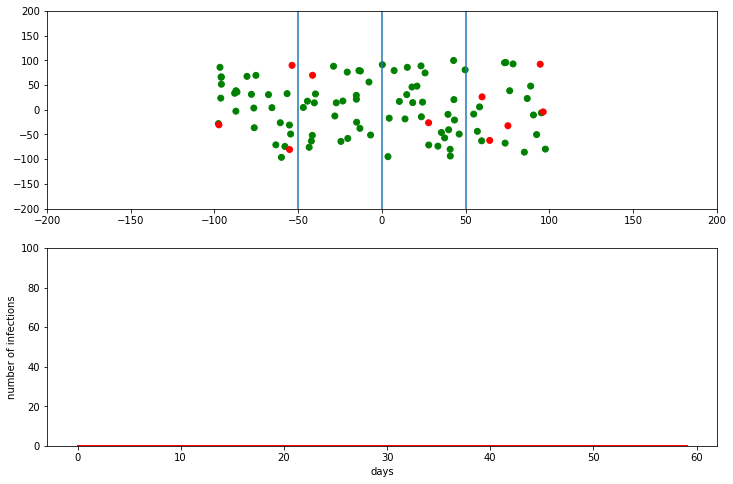

In [622]:
global people,region,ms,population,location,speed,compartment,infected,total_susceptible,total_infected,total_recovered,total_dead,color

#------------------------------------------------------------
# set up initial state
np.random.seed(0)               # common random numbers are used for fair comparison among scenarios

#reputting every parameter here

N     = 100
p_inf = 0.5   # probability of infecting by an infected individual (could be effect of wearing mask)
n_inf = 10    # total number of infected when we start the simulation (how soon the model be used to take action)
D     = 60    # number of days for which the simulation is to be run
n_com = 4     # number of compartments
dist  = 5     # range of a point where a user can move from its current point
move  = 5     # how much an individual move in the region (for example some may move more for work etc)
population = CreatePopulation(N,n_inf,n_com)

# if you have more than one compartments, restriction can be applied after some days
n_com             = 4           # number of compartments
restriction_apply = 20          # restrictions apply after these many days (quarantine or movement restriction)

people  = COVID(population,n_com,dist,p_inf,move,restriction_apply)

for p,person in enumerate(population):
    people.location[p,0] = person.x           # x location
    people.location[p,1] = person.y           # y location
    people.speed[p,0]    = person.x           # x speed
    people.speed[p,1]    = person.y           # y speed
    people.compartment[p,0] = person.compartment # contains the right side of the x
    people.infected[p,0]    = person.infected

# collecting metric
total_infected    = np.zeros((1,D))
total_recovered   = np.zeros((1,D))
total_susceptible = np.zeros((1,D))
total_dead        = np.zeros((1,D))

#assigning colors
color      = np.array(['green']*N)
ind = np.where(people.infected>0)[0]
color[ind]   = 'red'
people.color = color

#------------------------------------------------------------
# set up figure and animation
# thie figure the initial conditions of the region
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
region  = ax1.scatter(people.location[:,0], people.location[:,1],facecolors=people.color)
ax1.set_xlim((-200,200))
ax1.set_ylim((-200,200))
for c in range(n_com-1):
    xl = -100+200*(c+1)/(n_com)
    ax1.axvline(x=xl)

metrics_data = np.append(total_infected,total_susceptible,axis=0).T
metrics, = ax2.plot(range(D),total_infected.reshape(-1,1),lw=3,c='red')
ax2.set_ylim((0,N))
ax2.set_ylabel('number of infections')
ax2.set_xlabel('days')

def animate(d):
    """perform animation step
       d refers to the time in the simulation (here d means the number of days)
    """
    global ax1, ax2, fig, people, region
    
    # update pieces of the animation
    people.step(d)                             # 30 frames per second
    region.set_facecolors(people.color)
    region.set_offsets(people.location)
    
    total_infected[0,d]    = np.sum(people.infected)
    metrics.set_data(range(d),total_infected.reshape(-1,1)[:d])

In [623]:
ani = animation.FuncAnimation(fig,animate,frames=D,interval=100)
HTML(ani.to_html5_video())

In [611]:
people.compartment

array([[ 50.],
       [  0.],
       [ 50.],
       [ 50.],
       [ 50.],
       [-50.],
       [ 50.],
       [  0.],
       [ 50.],
       [ 50.],
       [ 50.],
       [-50.],
       [ 50.],
       [  0.],
       [-50.],
       [-50.],
       [  0.],
       [ 50.],
       [-50.],
       [  0.],
       [-50.],
       [-50.],
       [-50.],
       [ 50.],
       [ 50.],
       [  0.],
       [-50.],
       [-50.],
       [  0.],
       [ 50.],
       [ 50.],
       [  0.],
       [-50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [  0.],
       [ 50.],
       [ 50.],
       [  0.],
       [  0.],
       [ 50.],
       [  0.],
       [ 50.],
       [  0.],
       [  0.],
       [ 50.],
       [ 50.],
       [ 50.],
       [-50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [-50.],
       [-50.],
       [-50.],
       [-50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [  0.],
       [ 50.],
       [-50.],
       [  